In [3]:
import astropy.io.fits as pf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
import multiprocessing
import subprocess
import glob
import re
import h5py
%matplotlib inline

### Directorios del proyecto

In [4]:
DIR_PROYECTO       = '/home/matias/tesis/'
DIR_MOSAICOS       = DIR_PROYECTO + 'eagle/*/regiones/'
DIR_CATÁLOGOS      = DIR_PROYECTO + 'eagle/*/catálogos/'
DIR_SEGMENTACIONES = DIR_PROYECTO + 'eagle/*/segmentaciones/'
DIR_MORFOLOGÍAS    = DIR_PROYECTO + 'morfologías/'
DIR_DATOS_EAGLE    = DIR_PROYECTO + 'tablas/'
DIR_LOTZ           = DIR_PROYECTO + 'gm20/'

### Definición de valores de filtro

In [6]:
valores_filtros = {
    'u': 121671348.887,
    'g': 168273491.446,
    'r': 178848396.083,
    'i': 69397708.7252,
    'z': 59157262.0017,
    'upri': 126207773.267,
    'gpri': 149732062.76,
    'rpri': 188318397.068,
    'ipri': 67579475.1401,
    'zpri': 50496673.9991,
}

### Generación del mapa de pesos

In [4]:
hdu = pf.PrimaryHDU(np.ones((256, 256)))
hdu.writeto(DIR_PROYECTO + 'wht1.fits', overwrite=True)

### Generación de archivos para correr el programa de Lotz en modo 'batch'
`zeropt.dat` tiene las magnitudes de base de los mosaicos y `run_gmorph.pro` los mosaicos a procesar. Se generan en el mismo bucle para que el orden de las magnitudes se corresponda con el de los mosaicos.

Borramos los lotes existentes...

In [7]:
for file in glob.glob('*.pro'):
    os.remove(file)

Debido a un error del programa de Lotz que hace que el IDL arroje la excepción "program code area full" en vez de generar un único lote con todos los mosaicos a procesar, generamos varios lotes de hasta 100 mosaicos cada uno. 

In [8]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [24]:
N = 100 # chunk size

for filtro_orientación in os.listdir('../eagle'):
    nombre_filtro = filtro_orientación.split('_')[0]
    
    for index, chunk in enumerate(chunks(os.listdir('../eagle/' + filtro_orientación + '/regiones'), N)):
    
        with open('run_gmorph_' + filtro_orientación + '_%02d.pro' % index, 'w') as run_gmorph:
    
            for basename_región in chunk:
                
                fits = pf.open('../eagle/' + filtro_orientación + '/regiones/' + basename_región)
                
                flujo_total_filtro    = np.sum(fits[0].data) / valores_filtros[nombre_filtro] # flujo total / valor de filtro
                magnitud_total_filtro = -2.5 * np.log10(flujo_total_filtro / (3.631e6 * 4.8532896**2))

                nombre = os.path.splitext(basename_región)[0] # separa el nombre del archivo de su extensión

                comando = "get_gmorph_new, 0, '%s', '%s', '%s', '%s', '%s', %s" % (                                  \
                    # catálogo
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/catálogos/'      + nombre + '.fits.cat',    \
                    # región
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/regiones/'       + nombre + '.fits.reg',    \
                    # mapa de pesos
                    '/home/matias/tesis/wht1.fits',                                                                  \
                    # mapa de segmentación
                    '/home/matias/tesis/eagle/' + filtro_orientación + '/segmentaciones/' + nombre + '.fits.seg',    \
                    # archivo de salida
                    '/home/matias/tesis/morfologías/' + nombre + '.morph',                                           \
                    # magnitud total filtro
                    magnitud_total_filtro                                                                            \
                )

                # Cada línea luce como: get_gmorph_new, 0, 'xxx.cat', 'xxx.reg', 'wht1.fits', 'xxx.seg', 'xxx.morph'
                # "where 0 is the line number in xxx.cat of the starting object"
                run_gmorph.write(comando + '\n')

            run_gmorph.write('exit')

Borramos las morfologías existentes...

In [9]:
for file in glob.glob('../morfologías/*.morph'):
    os.remove(file)

Procesamos los lotes con IDL; lo hacemos en paralelo para aprovechar todos los núcleos de la computadora.

In [9]:
def idl(x):
    subprocess.run(['idl', x])
    
with multiprocessing.Pool(3) as p:
    p.map(idl, glob.glob('*.pro'))

Unimos todos los archivos creados por el programa de Lotz en uno solo. Hay una galaxia por archivo. Además extraemos la ID de la galaxia del nombre del archivo —ya que el programa de Lotz no se fija en esto— y la incluimos dentro del archivo que estamos generando para después tenerlas a mano.

In [10]:
with open('compendio.morph', 'w') as compendio:
    for file in glob.glob('../morfologías/*.morph'):
        id = re.search('\d+', file).group(0)
        
        with open(file, 'r') as morfología:    
            for line in morfología:
                if line[0] != '#': # si no es un comentario...
                    compendio.write(id + line)

### Carga de la consulta a la base de datos de EAGLE

In [7]:
encabezado = [
  'id',
  'sfr',
  'm_dm',
  'm_gs',
  'm_st',
  'r_hm',
  'u_mag',
  'g_mag',
  'r_mag'
]

columnas = [0,1,2,3,4,5,10,11,12]

eagle_data = pd.read_csv('/home/matias/tesis/tablas/eagle_db_fits_27.dat', names=encabezado, usecols=columnas)

eagle_data['color_gr'] = eagle_data.g_mag - eagle_data.r_mag

# Magnitudes del SDSS a U-B: U-B = 0.78 * (u - g) - 0.88
eagle_data['color_ub'] = 0.78 * (eagle_data.u_mag - eagle_data.g_mag) - 0.88

### Carga de las morfologías (salida del programa de Lotz)
Do not trust morphologies when `FLAG=1` and/or `<S/N> < 2.5`  and/or `R_ell < 2 x PSF FWHM` (see Lotz et al. astro-ph/0509106).

In [5]:
encabezado = [
  'id',
  's_n',
  'r_ell', # elliptic petrosian radius
  'gini',
  'm20',
  'flag'
]

columnas = [0,6,10,20,21,22]

lotz_data = pd.read_csv('compendio.morph', names=encabezado, usecols=columnas, sep='\s+')

lotz_data = lotz_data[(lotz_data.flag == 0) & (lotz_data.s_n >= 2.5)]

### Join EAGLE con Lotz

In [8]:
df = pd.merge(eagle_data, lotz_data, how='inner', on='id')

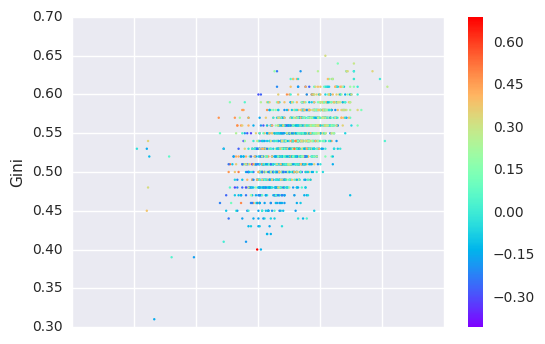

In [18]:
df.plot.scatter(x='m20', y='gini', c=df.color_ub, s=3, edgecolor='none', cmap='rainbow')

plt.xlim(plt.xlim()[::-1])
#plt.colorbar()
plt.ylim(.3,.7)
plt.xlabel('M20')
plt.ylabel('Gini')
plt.savefig('gini_m20.png')

Los datos que procesé son galaxias *face on* en filtro *R*. La idea es procesar otras orientaciones y otros filtros.
* g_face
* g_rand
* r_face
* (rpri_face)

**Publicaciones**
Abrham: antecedente de Lotz (no es tan importante).
Snyder: Gini-M20 Illustris.
Torrey: fits Illustris.
Trayford: fits EAGLE.
Lotz: código.

**TODO**

* ¿Qué hace el código de Lotz con los parámetros de `morph.dat` (como PSF)?

* Del paper de Snyder realizar las mismas figuras para Eagle (excepto rpri)
  1. Figura 2
  2. Figura 4 (excepto el subplot 3)
  
* necesito la función de distancia F
* necesito SFR específico y la masa de las galaxias 

## Illustris

http://www.illustris-project.org/data/docs/specifications

In [83]:
morfologías = h5py.File('../illustris/nonparametric_morphologies.hdf5', 'r')
circularidades = h5py.File('../illustris/stellar_circs.hdf5', 'r')

filtros = ['gSDSS', 'iSDSS', 'uSDSS', 'hWFC3']
cámaras = ['cam0', 'cam1', 'cam2', 'cam3']

In [137]:
df = pd.DataFrame()

for filtro in filtros:
    for cámara in cámaras:
        m = pd.DataFrame()
        
        m['id']   = morfologías['Snapshot_135/SubfindID_%s' % cámara]
        
        m['filtro'] = filtro
        m['cámara'] = cámara
        
        m['gini'] = morfologías['Snapshot_135/%s/Gini_%s'   % (filtro, cámara)]
        m['m20']  = morfologías['Snapshot_135/%s/M20_%s'    % (filtro, cámara)]
        m['concentration']     = morfologías['Snapshot_135/%s/C_%s'  % (filtro, cámara)]
        m['petrosian_radius']  = morfologías['Snapshot_135/%s/RP_%s' % (filtro, cámara)]
        m['half_light_radius'] = morfologías['Snapshot_135/%s/RE_%s' % (filtro, cámara)]
        
        df = pd.concat([df, m])

In [138]:
c = pd.DataFrame()

c['id'] = circularidades['Snapshot_135/SubfindID']
c['specific_angular_momentum'] = circularidades['/Snapshot_135/SpecificAngMom']
c['e']  = circularidades['Snapshot_135/CircAbove07Frac']

df = pd.merge(df, c, how='inner', on='id')
df.set_index('id', inplace=True)

In [136]:
df.groupby(['filtro', 'cámara'])

In [140]:
df2 = df[(df.filtro == 'gSDSS') & (df.cámara == 'cam0')]

(0.0, -3.5)

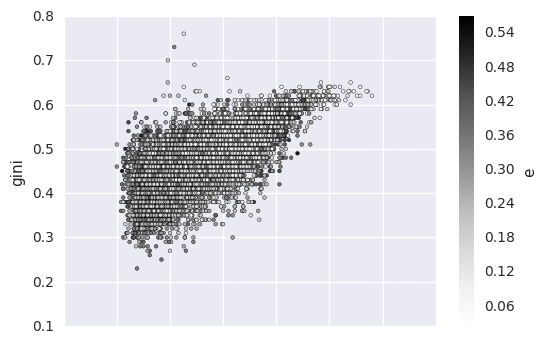

In [151]:
df2.plot.scatter(x='m20', y='gini', c='e', s=7)
plt.xlim(plt.xlim()[::-1])